In [1]:
%load_ext autoreload
%autoreload 2

# Getting started with granite-geospatial-surface-urban-heat

This notebook demonstrates the usage of the granite-geospatial-surface-urban-heat model hosted on huggingface for the downscaling (spatially) of Land Surface Temperature (LST).

The granite-geospatial-surface-urban-heat model is a fine-tuned geospatial foundation model that predicts/downscales LST from Harmonized Landsat and Sentinel-2 (HLS) L30 optical satellite imagery and ERA5-Land near-surface air temperature $(T_{2m})$. It was fine-tuned using training labels from LST calculated from the HLS L30 optical satellite imagery that has been sampled for 28 cities representing a diverse set of bio-climatic zones across the globe. 

Please see the [model card](https://github.ibm.com/NIH-HE2AT/granite-geospatial-surface-urban-heat/blob/main/model-card.md) for more information on the model development, including the base foundation model. The input data contained 14 layers, 6 HLS band layers [B02-B07], 4 ERA5-Land ${T_2m}$ layers and sine and cosine of the Time-of-Day (TOD) and sine and cosine of the Day-of-Year (DOY). The final model only utilised 7 layers: 6 HLS band layers [B02-B07] and the spatial mean of the ERA5-Land ${T_2m}$ at the time of acquisition. 

This notebook guides the user on the use of the granite-geospatial-surface-urban-heat model for:

1. __Inferencing for all cities:__ The granite-geospatial-surface-urban-heat model is loaded and downscaled LST predictions are inferenced on the test data (timestamps/patches or cities) which was not seen during fine-tuning.
2. __Box and Violin Plots:__ A box and whispers plot for the MAE of the predictions per city is plotted. If you prefer violin plots, we have you covered and add that as an alternative option.
3. __Comparison plots:__ The predictions from the previous step are compared to the ground truth. The RGB composite image for the patches/tiles for various cities are plottted along with the corresponding prediction, ground truth, error map, histograms and scatter plots to visualise the model performance. 

The granite-geospatial-surface-urban-heat model weights are available from the Hugging Face IBM Granite Model Repository (LINK). The required data to complete the experiments in this notebook is available through Zenodo (LINK).

# Setting up your environment

The granite-geospatial-surface-urban-heat model is trained using the [Terratorch framework](https://github.com/IBM/terratorch/). Terratorch simplifies the integration of foundation model backbones into the TorchGeo framework and provides generic LightningDataModules that can be built at runtime. For more information on Terratorch, please refer to the instructions in the [Terratorch Quick Start Guide](https://ibm.github.io/terratorch/quick_start/).

## If running locally

Before running the notebook, make sure you have created a python environment and installed the directory granite-geospatial-surface-urban-heat using:

```
cd granite-geospatial-surface-urban-heat
pip install -e .
```

This will install pytorch and Terratorch for you, amongst a few other libraries.

In [ ]:
# Clone the ibm-granite/granite-geospatial-biomass GitHub
!git clone https://github.com/ibm-granite/granite-geospatial-surface-urban-heat.git

# Change directory. Move inside the tsfm repo.
%cd granite-geospatial-surface-urban-heat

# Install the package
!pip install -e .

# Change directory. Standardize so below paths work with local notebook and colab.
%cd notebooks

## Running the code

In [2]:
# Standard
import os
import shutil
import glob
import yaml
import pandas as pd
import numpy as np
import subprocess
from pathlib import Path

# Third Party
import rioxarray as rio
from lightning.pytorch import Trainer
from terratorch.cli_tools import LightningInferenceModel
import terratorch
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

# First Party
from utils.plotting import plot_rgb_lst_distribution_scatter
from utils.plotting import plot_box_plot
from utils.plotting import plot_violin_plot

In [ ]:
%pwd

# Data and model preparation

Let's start with downloading the datasets from Zenodo:

In [3]:
# Download dataset from Zenodo
# dataset_path = '../granite-geospatial-biomass-datasets.tar.gz'
# !wget "https://zenodo.org/records/12356481/files/granite-geospatial-biomass-datasets.tar.gz?download=1" -O {dataset_path}
dataset_path = 'granite-geospatial-surface-urban-heat-dataset.tar.gz'
!wget "https://ibm.box.com/shared/static/seoe40aqva2f639uigu1hmqxf30vke09.gz?download=1" -O {dataset_path}

In [3]:
# Unpack compressed dataset
# target_directory = '../'
target_directory = '/dccstor/sarl_data/muaazb/'
!tar -xf {dataset_path} --directory {target_directory}

Download the model checkpoint from HuggingFace:

In [4]:
# ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-biomass", filename="biomass_model.ckpt")
ckpt_path = '/dccstor/sarl_data/muaazb/granite-surface-urban-heat/checkpoints/SUHI_model.ckpt'
!wget "https://ibm.box.com/shared/static/nx6rzge17lk86v0izba0vygy8nugb79o.ckpt?download=1" -O {ckpt_path}

## Inferencing for all cities
For the first step, we use the granite-geospatial-surface-urban-heat model for inference on test data which was not seen during finetuning (for cities that were seen but for patches/timestamps that were not seen and for unseen cities). Predictions of LST at a $30 m$ resolution are made using the HLS L30 data and ERA5-Land $T_{2m}$ at a $9 km$ resolution.

In [5]:
config_path = '../configs/config.yaml'
conf = yaml.safe_load(Path(config_path).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"
test_inputs_dir = os.path.join(target_directory, 'granite-geospatial-surface-urban-heat-dataset', 'inputs/')
assert os.path.isdir(test_inputs_dir), f"Directory not found: {test_inputs_dir}"
inference_path = '/dccstor/sarl_data/muaazb/granite-surface-urban-heat/inference'
os.makedirs(inference_path, exist_ok=True)
run_str = f"terratorch predict -c {config_path} --ckpt_path {ckpt_path} --predict_output_dir {inference_path} --data.init_args.predict_data_root {test_inputs_dir} --data.init_args.predict_dataset_bands {data_bands}"

print(f"Running inference:")
print(run_str)

#If the below block of code where subprocess.call does not work, comment it out and use the run string and do the inferencing via the CLI.

subprocess.call(['terratorch', 'predict', '-c', config_path,
                 '--ckpt_path', ckpt_path, 
                 '--predict_output_dir', inference_path, 
                 '--data.init_args.predict_data_root', test_inputs_dir, 
                 '--data.init_args.predict_dataset_bands', data_bands])
print("---------- Complete ----------")
print("========== DONE ==========")

Running inference:
terratorch predict -c ../configs/config.yaml --ckpt_path /dccstor/sarl_data/muaazb/granite-surface-urban-heat/checkpoints/SUHI_model.ckpt --predict_output_dir /dccstor/sarl_data/muaazb/granite-surface-urban-heat/inference --data.init_args.predict_data_root /dccstor/sarl_data/muaazb/granite-geospatial-surface-urban-heat-dataset/inputs/ --data.init_args.predict_dataset_bands [BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,7]
---------- Complete ----------
========== DONE ==========


## Plot box and whisker plots for all inferenced cities
For the second step, we plot a box and whiskers plot for the predictions on test data which was not seen during finetuning (for cities that were seen but for patches/timestamps that were not seen and for unseen cities). 

From the four cities in the dataset provided, Abidjan, Johannesburg, and Paris were cities that model has seen during training. Baltimore is an unseen city. 

The plot generated below plots the Mean Absolute Error (MAE) of the LST, the corresponding standard deviations and outliers from the predictions for eaach city

Note: This code block will take a few minutes to generate the plot as statistics are calculated on each patch and then aggregated per city. 

Results directory exits!


Comparison plots directory exits!




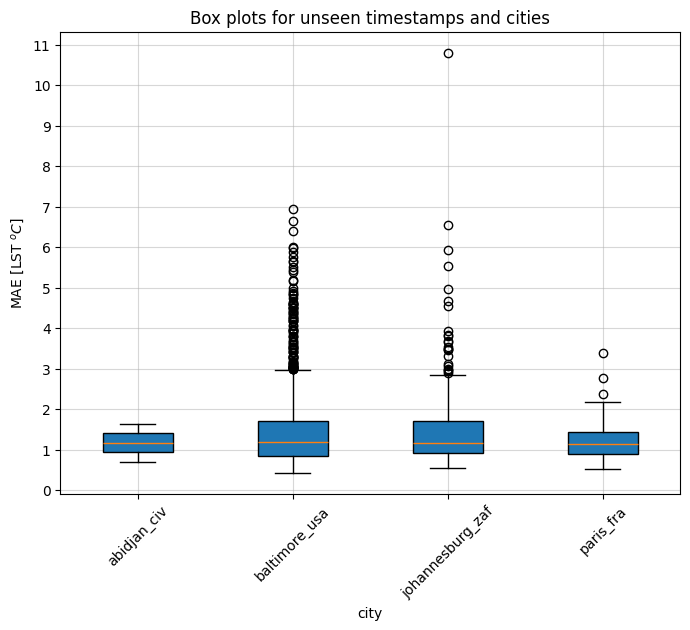

In [6]:
test_targets_dir = os.path.join(target_directory, 'granite-geospatial-surface-urban-heat-dataset', 'targets/')
results_path = '/dccstor/sarl_data/muaazb/granite-surface-urban-heat/results'
plot_box_plot(test_targets_dir, inference_path, results_path, save_plot=True)

### If you prefer a Violin Plot we have you covered.

Results directory exits!


Comparison plots directory exits!




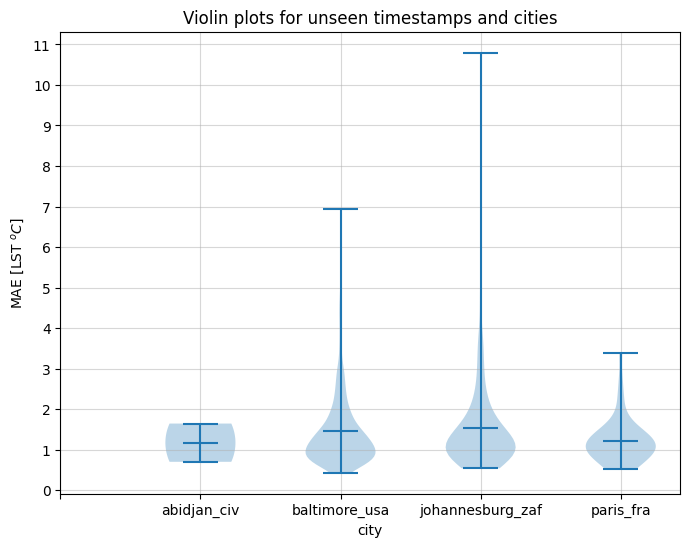

In [7]:
plot_violin_plot(test_targets_dir, inference_path, results_path, save_plot=True)

The box and whiskers plot as well as the violin plot highlights that overall the model performance for unseen cities is on par with predictions for cities that the model was trained on, highlighting the generalisability of the model. This will be further demonstrated in the subseqeuent part of the notebook where the RGB composite image for the patches/tiles for various cities are plottted along with the corresponding prediction, ground truth, error map, histograms and scatter plots to visualise the model performance. 

## Comparison plots
For the final step, the RGB composite image for the various patches/tiles for various cities are plottted along with the corresponding prediction, ground truth, error map, histogram and scatter plot to visualise the model performance. 

We will plot two prediction per city in the dataset:

Seen cities (unseen timestamp/patch):

1. abidjan_civ.T30NUL.index_7_224.20171225.T102814.inputs.tif
2. abidjan_civ.T30NUM.index_4_224.20180126.T102800.inputs.tif
3. johannesburg_zaf.T35JNL.index_0_224.20150714.T100152.inputs.tif
4. johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs.tif
5. paris_fra.T31UDP.index_0_224.20190704.T114044.inputs.tif
6. paris_fra.T31UDQ.index_10_224.20200519.T113951.inputs.tif

Unseen city (unseen timestamp/patch):

7. baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs.tif
8. baltimore_usa.T18SUJ.index_21_224.20230730.T104543.inputs.tif

In [8]:
patches = ['abidjan_civ.T30NUL.index_7_224.20171225.T102814.inputs.tif',
           'abidjan_civ.T30NUM.index_4_224.20180126.T102800.inputs.tif',
           'johannesburg_zaf.T35JNL.index_0_224.20150714.T100152.inputs.tif',
           'johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs.tif',
           'paris_fra.T31UDP.index_0_224.20190704.T114044.inputs.tif', 
           'paris_fra.T31UDQ.index_10_224.20200519.T113951.inputs.tif',
           'baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs.tif',
           'baltimore_usa.T18SUJ.index_21_224.20230730.T104543.inputs.tif'
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Results directory exits!


Comparison plots directory exits!


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/abidjan_civ.T30NUL.index_7_224.20171225.T102814.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/abidjan_civ.T30NUM.index_4_224.20180126.T102800.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/johannesburg_zaf.T35JNL.index_0_224.20150714.T100152.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/paris_fra.T31UDP.index_0_224.20190704.T114044.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/paris_fra.T31UDQ.index_10_224.20200519.T113951.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/comparison_plots/baltimore_usa.T18SUJ.index_21_224.20230730.T104543.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


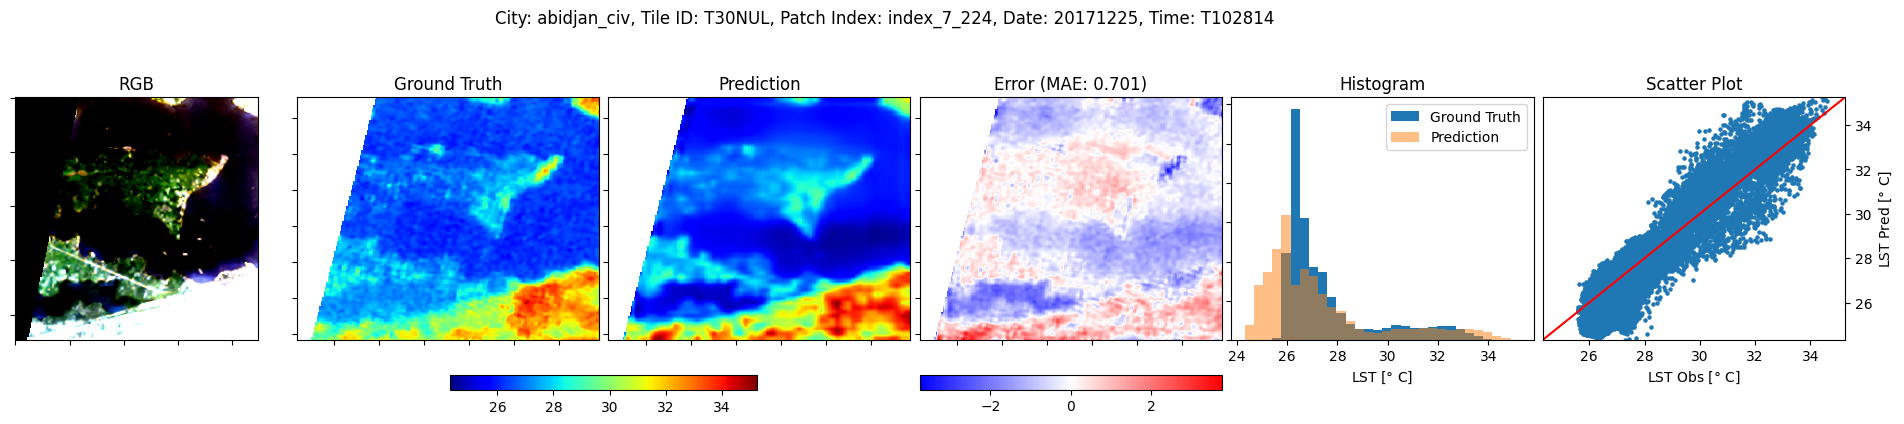

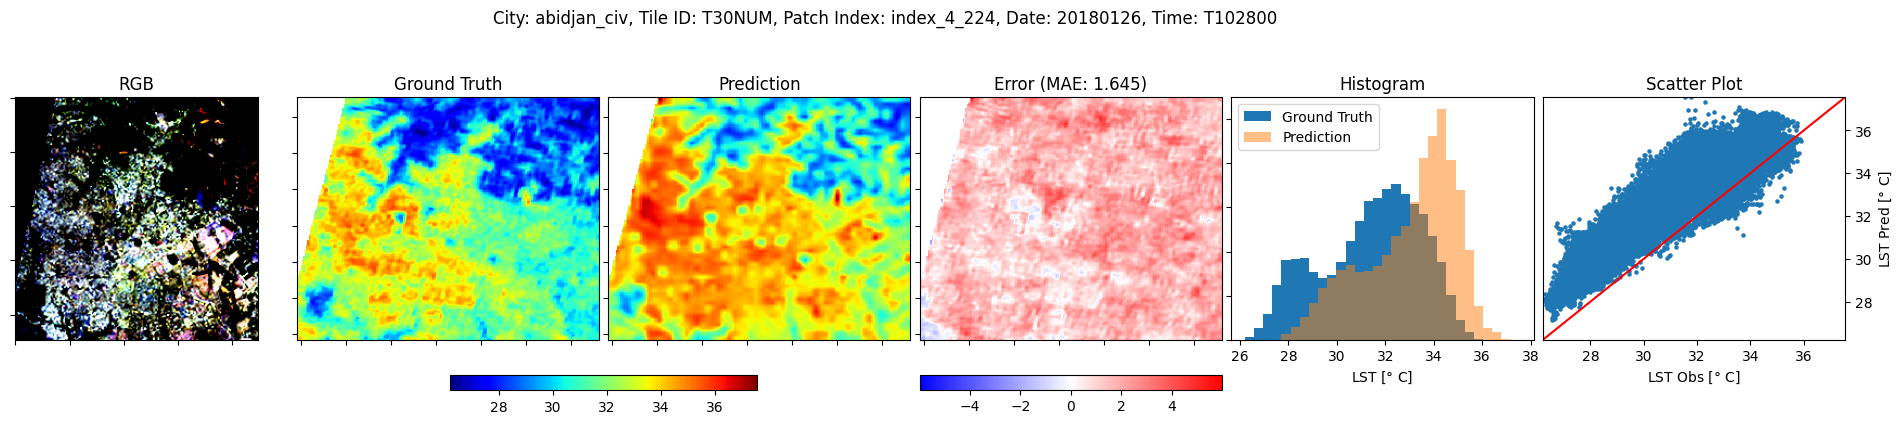

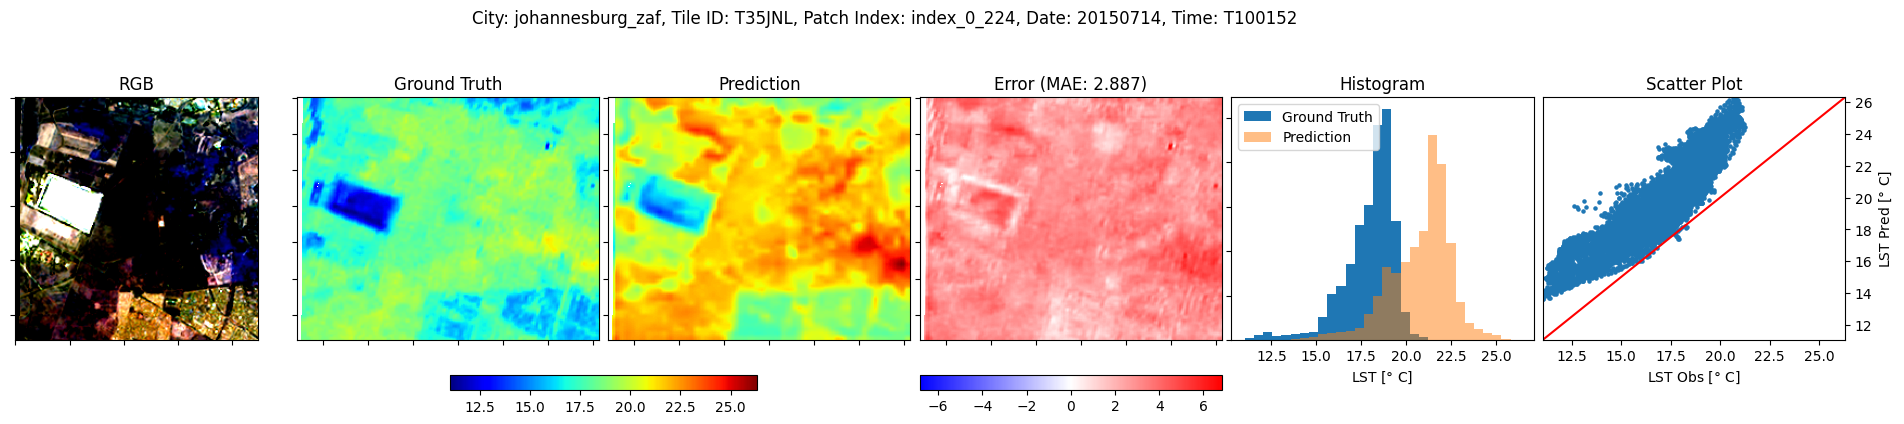

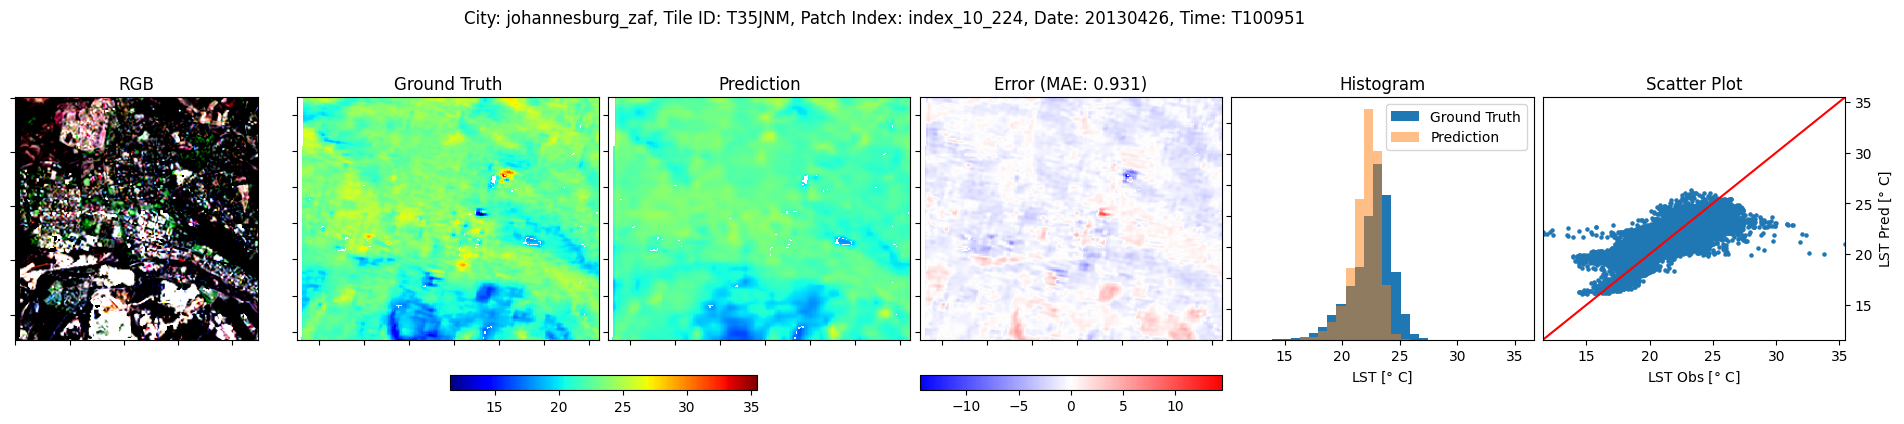

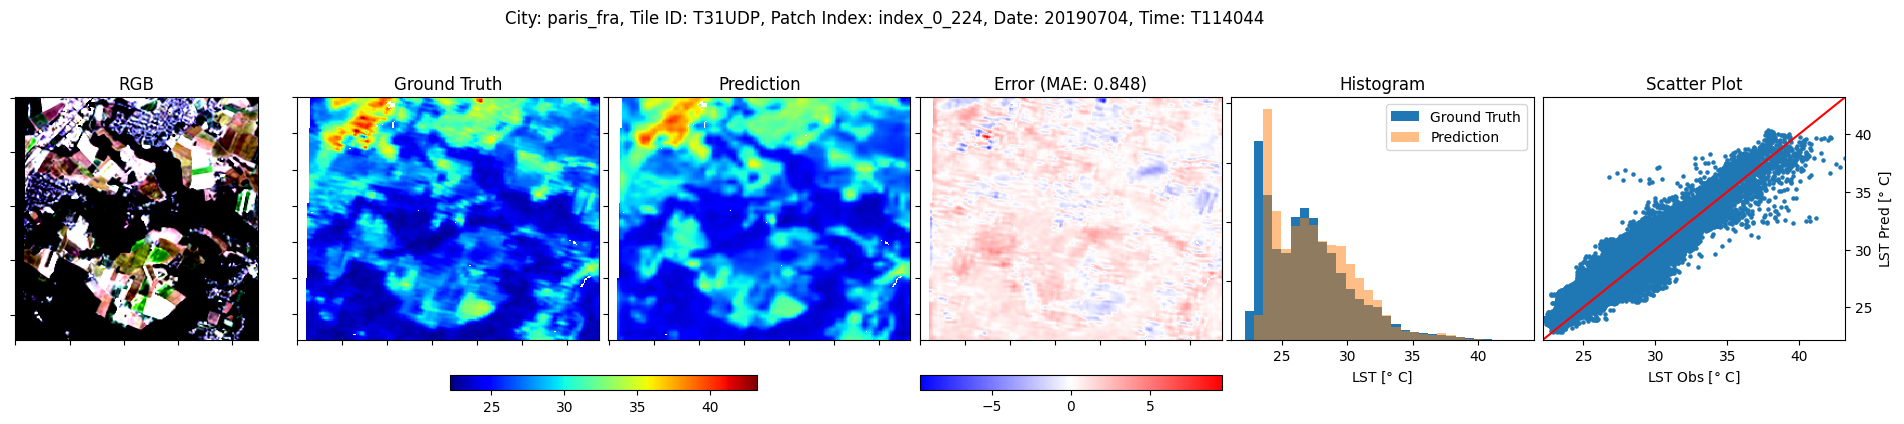

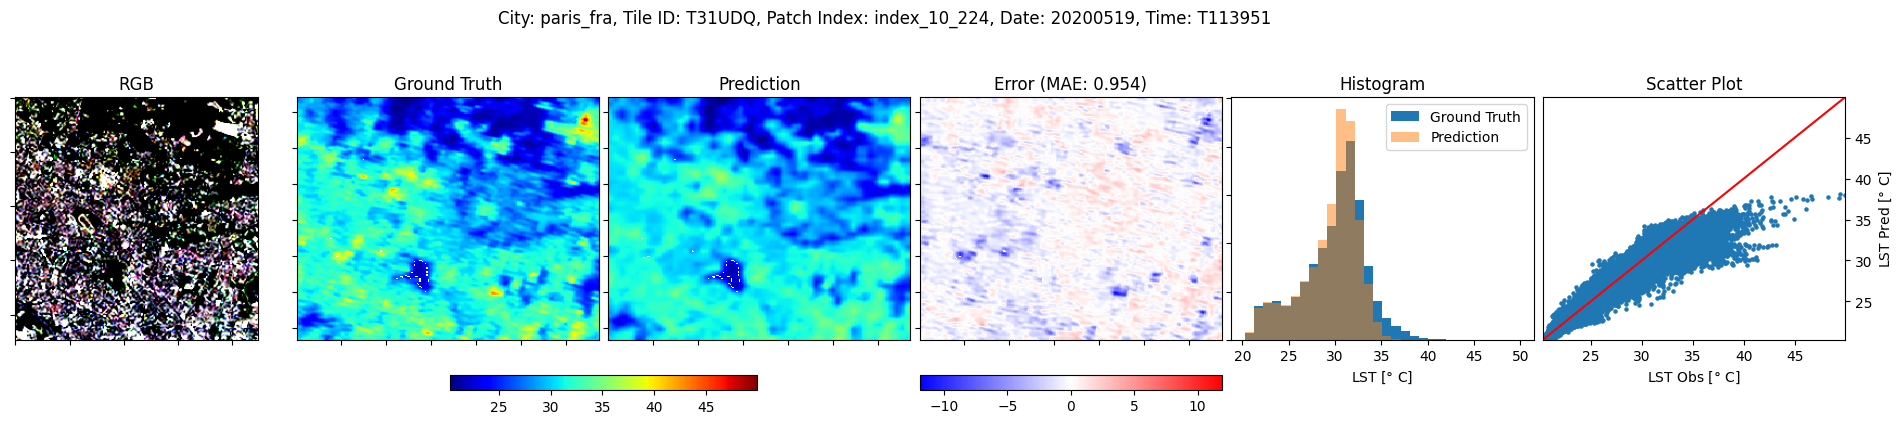

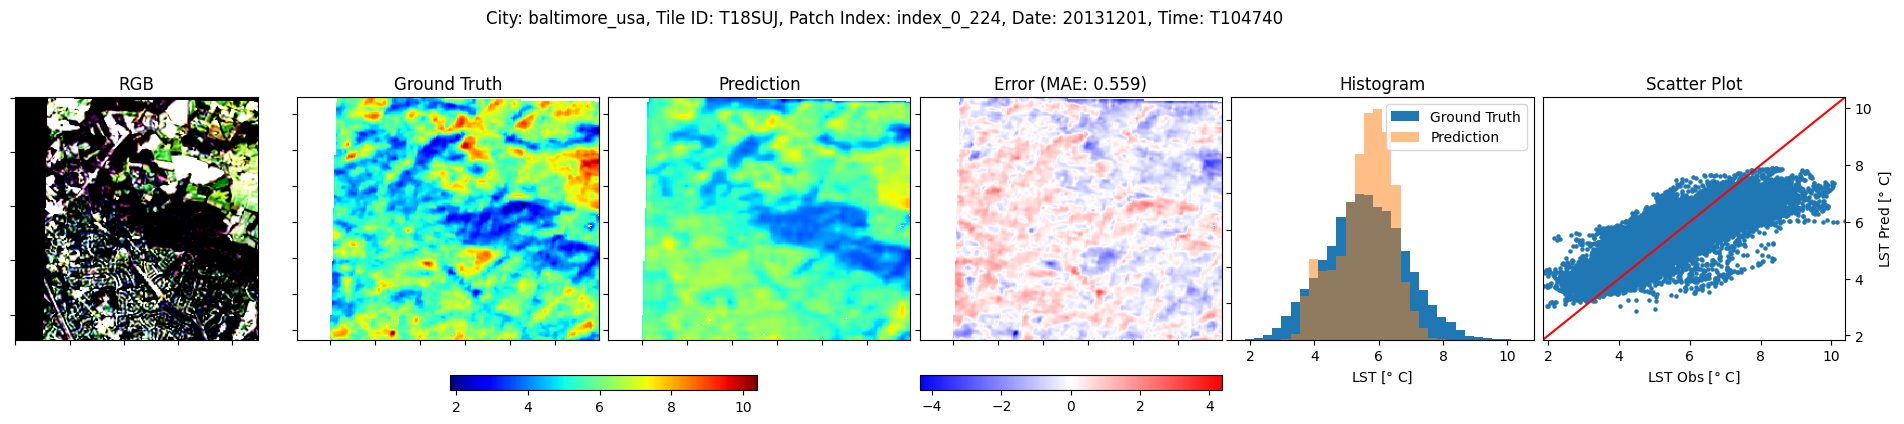

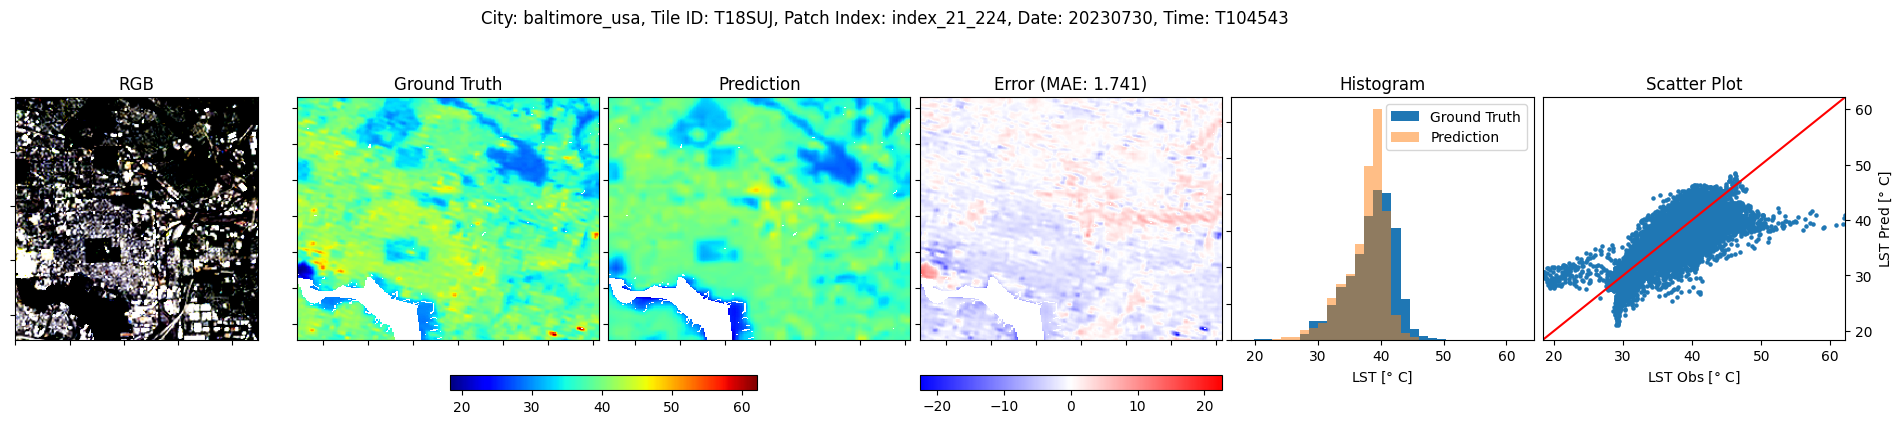

In [9]:
plot_rgb_lst_distribution_scatter(patches, test_targets_dir, inference_path, results_path, test_inputs_dir, save_plot=True)

# Predictions on full tiles (an entire city):

This process will follow the same steps as was the case for patches. We proceed to use Baltimore, USA as an example of this. 

The steps are:
1. Data Download
2. Inferencing
3. Plots to assess model predictions

In [10]:
# Download dataset from Zenodo
# dataset_path = '../granite-geospatial-biomass-datasets.tar.gz'
# !wget "https://zenodo.org/records/12356481/files/granite-geospatial-biomass-datasets.tar.gz?download=1" -O {dataset_path}
dataset_path_tiles = 'granite-geospatial-surface-urban-heat-dataset-full-tiles.tar.gz'
!wget "https://ibm.box.com/shared/static/seoe40aqva2f639uigu1hmqxf30vke09.gz?download=1" -O {dataset_path_tiles}

# Unpack compressed dataset
# target_directory = '../'
target_directory = '/dccstor/sarl_data/muaazb/'
!tar -xf {dataset_path_tiles} --directory {target_directory}

In [11]:
config_path = '../configs/config_full_tile.yaml' #This config file is better suited for inferencing on full/larger (larger than 224 x 224) tiles
conf = yaml.safe_load(Path(config_path).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"
test_inputs_dir = os.path.join(target_directory, 'granite-geospatial-surface-urban-heat-dataset-full-tiles', 'inputs/')
assert os.path.isdir(test_inputs_dir), f"Directory not found: {test_inputs_dir}"
inference_path = '/dccstor/sarl_data/muaazb/granite-surface-urban-heat/inference_tiles'
os.makedirs(inference_path, exist_ok=True)
run_str = f"terratorch predict -c {config_path} --ckpt_path {ckpt_path} --predict_output_dir {inference_path} --data.init_args.predict_data_root {test_inputs_dir} --data.init_args.predict_dataset_bands {data_bands}"

print(f"Running inference:")
print(run_str)

#If the below block of code where subprocess.call does not work, comment it out and use the run string and do the inferencing via the CLI.

subprocess.call(['terratorch', 'predict', '-c', config_path,
                 '--ckpt_path', ckpt_path, 
                 '--predict_output_dir', inference_path, 
                 '--data.init_args.predict_data_root', test_inputs_dir, 
                 '--data.init_args.predict_dataset_bands', data_bands])
print("---------- Complete ----------")
print("========== DONE ==========")

Running inference:
terratorch predict -c ../configs/config_full_tile.yaml --ckpt_path /dccstor/sarl_data/muaazb/granite-surface-urban-heat/checkpoints/SUHI_model.ckpt --predict_output_dir /dccstor/sarl_data/muaazb/granite-surface-urban-heat/inference_tiles --data.init_args.predict_data_root /dccstor/sarl_data/muaazb/granite-geospatial-surface-urban-heat-dataset-full-tiles/inputs/ --data.init_args.predict_dataset_bands [BLUE,GREEN,RED,NIR_NARROW,SWIR_1,SWIR_2,7]
---------- Complete ----------
========== DONE ==========


Results directory exits!


Comparison plots directory exits!




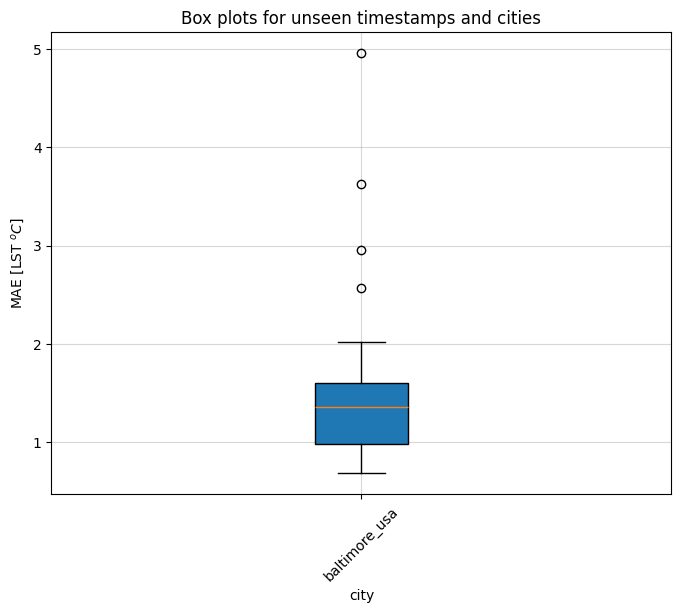

In [12]:
test_targets_dir = os.path.join(target_directory, 'granite-geospatial-surface-urban-heat-dataset-full-tiles', 'targets/')
results_path = '/dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/full_tiles'
plot_box_plot(test_targets_dir, inference_path, results_path, save_plot=True)

Results directory exits!


Comparison plots directory exits!




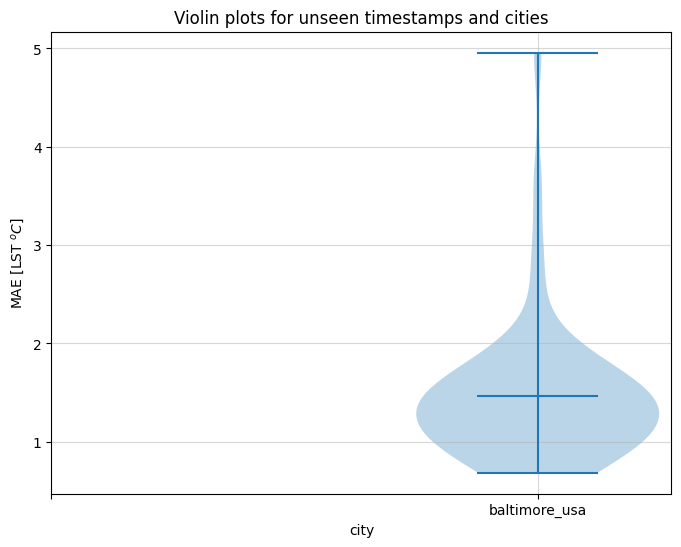

In [13]:
plot_violin_plot(test_targets_dir, inference_path, results_path, save_plot=True)

In [14]:
tiles = ['baltimore_usa.T18SUJ.20131201.T104740.inputs.tif',
         'baltimore_usa.T18SUJ.20141017.T104617.inputs.tif',
]

Results directory exits!


Comparison plots directory exits!




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/full_tiles/comparison_plots/baltimore_usa.T18SUJ.20131201.T104740.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving plot ..... /dccstor/sarl_data/muaazb/granite-surface-urban-heat/results/full_tiles/comparison_plots/baltimore_usa.T18SUJ.20141017.T104617.inputs_comp_plot_enhance.png


/dccstor/eevdata/envs/uhi-oss-test/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


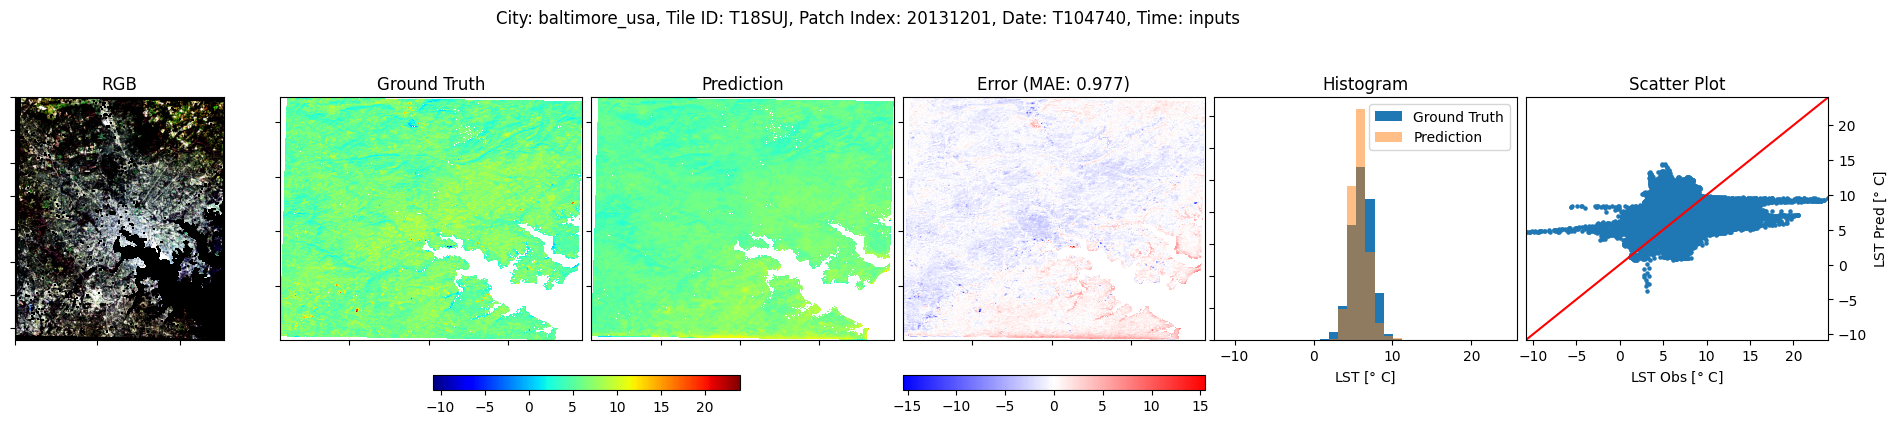

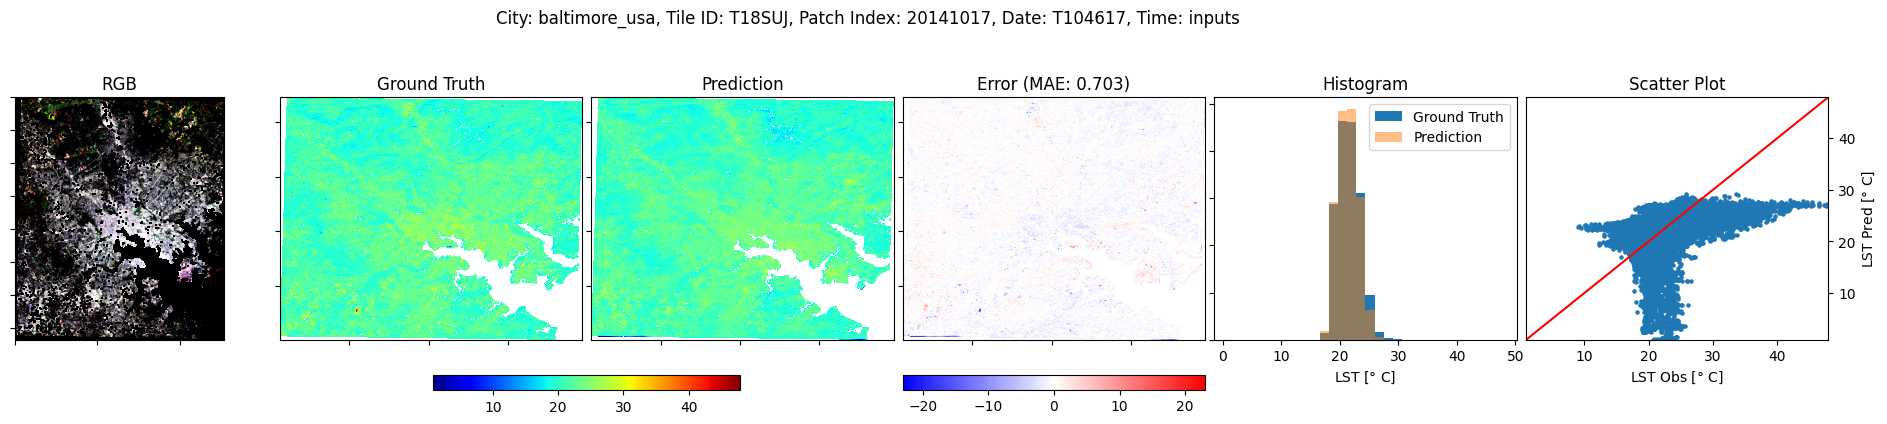

In [15]:
plot_rgb_lst_distribution_scatter(tiles, test_targets_dir, inference_path, results_path, test_inputs_dir, save_plot=True)

We hope this notebook provides you with the tools and understanding to drive innovation forward.